In [1]:
library(Seurat)
library(tximport)
library(dplyr)
library(ggplot2)
library(ggsci)
library(tidyverse)
library(pheatmap)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.3     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
files <- file.path("/data/Matthew/scrna/sc_align/zmays_salmon_shoot1/alevin/quants_mat.gz")
txi <- tximport(files, type = "alevin")
zma_obj <- CreateSeuratObject(counts = txi$counts, project = "Zmays_shoot1")

reading in alevin gene-level counts across cells with fishpond

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


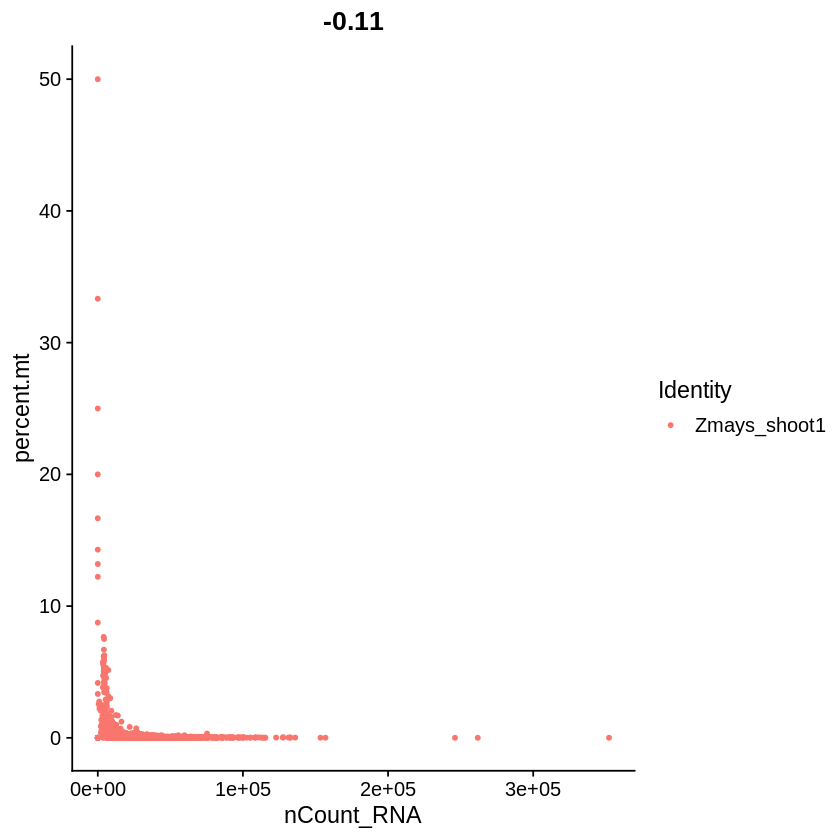

In [3]:
id_path <- "/data/Matthew/scrna/02.Clustering/id_latest/"

mt_genes <- readLines(paste(id_path, "zma_mt.id",sep = "/"))
zma_obj[["percent.mt"]] <- PercentageFeatureSet(zma_obj, features = mt_genes)

FeatureScatter(zma_obj, feature1 = "nCount_RNA", feature2 = "percent.mt")

In [4]:
zma_obj <- subset(
  zma_obj,
  subset =
    nFeature_RNA > 2500 &
#    nFeature_RNA < 10000 &
#    nCount_RNA < 50000 &
#    nCount_RNA > 500 &
    percent.mt < 1 #&
#    percent.chl < 10
)


In [5]:
options(warn = -1)

zma_obj <- zma_obj %>%
#     NormalizeData() %>%
#     FindVariableFeatures() %>%
#     ScaleData(vars.to.regress = c("CC.Difference"), verbose = F) %>%
    SCTransform(vars.to.regress = "percent.mt", verbose = FALSE) %>%
    RunPCA(verbose = F) %>%
#    RunTSNE(dims = 1:50) %>%
    RunUMAP(dims = 1:25, verbose = F) %>%
    FindNeighbors(dims = 1:25, verbose = F) %>%
    FindClusters(resolution = 0.5, verbose = F) %>%
    identity()
options(warn = 1)
table(zma_obj@active.ident)


   0    1    2    3    4    5    6    7    8    9   10 
1491 1437 1200 1143 1120  857  645  564  450  211  209 

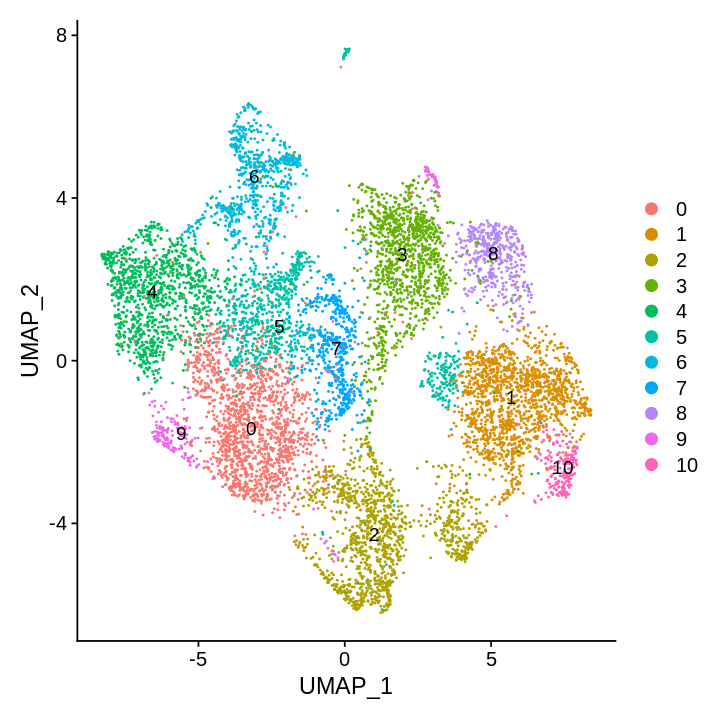

In [6]:
options(repr.plot.height = 6, repr.plot.width = 6)
p1 <- DimPlot(object = zma_obj, reduction = "umap", label = T)
p1

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: GRMZM2G068934”


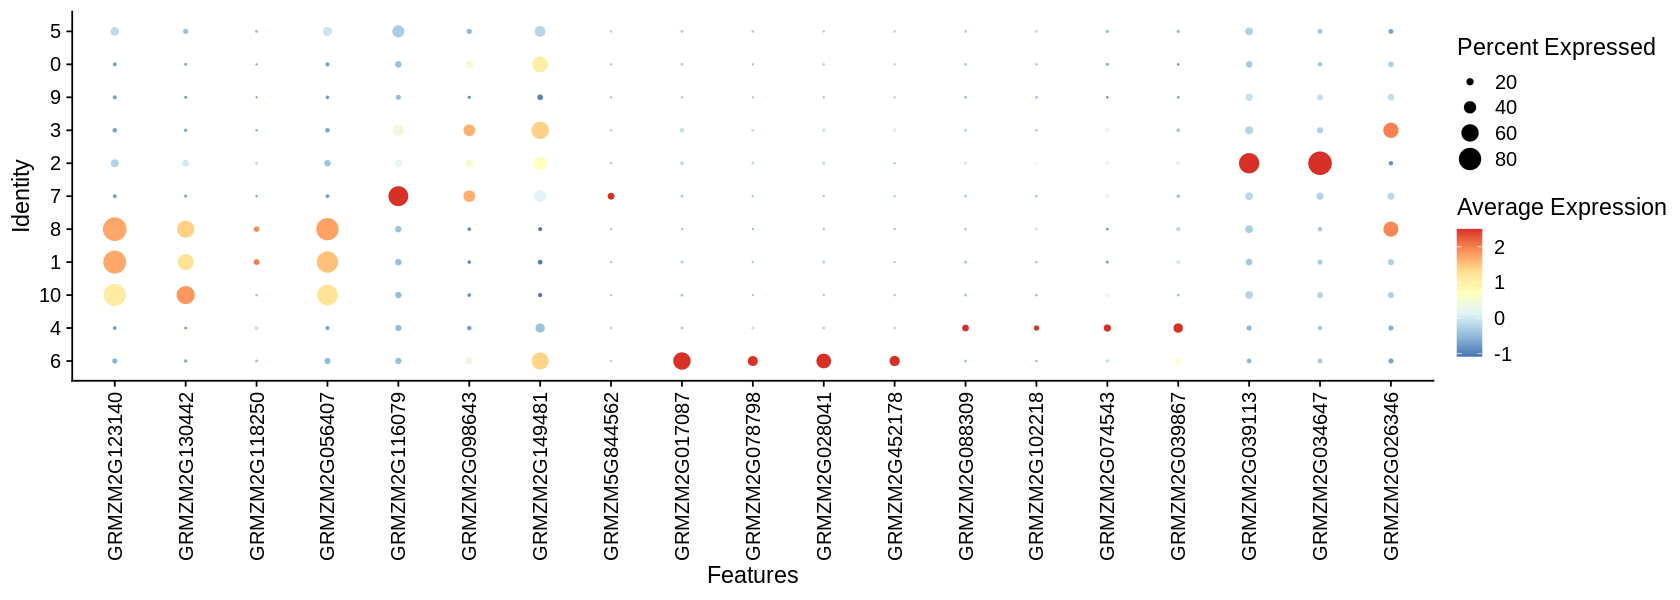

In [7]:
options(repr.plot.height = 5, repr.plot.width = 14)

celltype <- readLines(paste(id_path, "zma_celltype.id",sep = "/"))
p2 <- DotPlot(zma_obj, features = celltype, cluster.idents = T, cols = "RdYlBu") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
p2

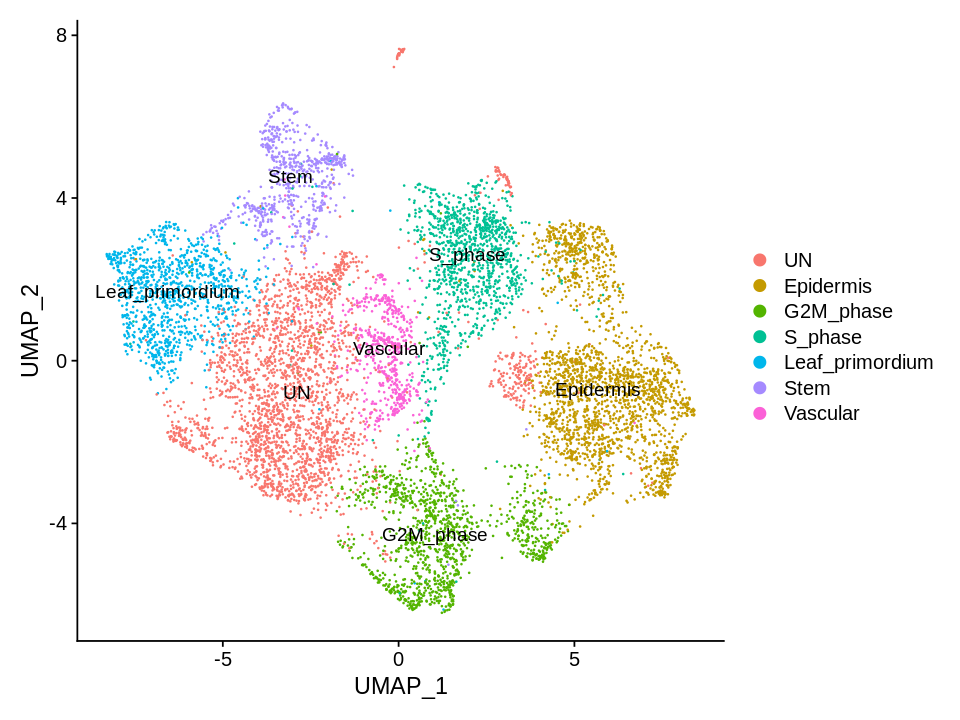

In [8]:
options(repr.plot.height = 6, repr.plot.width = 8)
# Alevin leaf
new.cluster.ids <- c("UN", "Epidermis", "G2M_phase", "S_phase", "Leaf_primordium", "UN",
                     "Stem", "Vascular", "Epidermis", "UN", "Epidermis")

# Add seurat object levels to new.cluster.ids 
names(new.cluster.ids) <- levels(zma_obj)
# Rename clusters
zma_obj <- RenameIdents(zma_obj, new.cluster.ids) 

zma_obj[["old.ident"]] <- Idents(object = zma_obj)
# t-SNE plot
# options(repr.plot.height = 6, repr.plot.width = 6)
p3 <- DimPlot(zma_obj, reduction = "umap", label = TRUE, pt.size = 0.1)
p3

In [9]:
zma_exp <- AverageExpression(zma_obj)
zma_exp$RNA %>% head()

Warning message in PseudobulkExpression(object = object, pb.method = "average", :
“Exponentiation yielded infinite values. `data` may not be log-normed.”


,UN,Epidermis,G2M_phase,S_phase,Leaf_primordium,Stem,Vascular
GRMZM2G356204,0.036823360,0.066450577,0.12075077,0.072599695,0.047659043,0.055655161,0.048465384
GRMZM2G054378,0.132103075,0.127874476,0.17509651,0.177623606,0.179204230,0.143984539,0.148769278
GRMZM2G356260,0.007070866,0.008214572,0.01167422,0.012793401,0.012304624,0.014679089,0.007243413
AC190834.3-FG005,0.000000000,0.000000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000
GRMZM2G054678,1.303505389,1.714472564,1.83312208,7.013522486,1.810167772,2.273143994,2.195155987
GRMZM2G089409,0.002521410,0.001949086,0.00000000,0.006580795,0.004602541,0.001005769,0.000000000


In [10]:
zma_index <- zma_exp$RNA %>%
  as.data.frame() %>%
  rownames_to_column(var = "zma_id") %>%
  as_tibble() %>%
  rowwise() %>%
  mutate(
    mean_gC = sum(c_across(Epidermis:Vascular)) / 5,
    VC_zma = Vascular / mean_gC,
    MC_zma = Leaf_primordium / mean_gC,
    EC_zma = Epidermis / mean_gC,
    Stem_zma = Stem / mean_gC,
    G2M_zma = G2M_phase / mean_gC,
    S_zma = S_phase / mean_gC,
  ) %>%
  select(zma_id, VC_zma:S_zma) %>% drop_na() %>%
  identity()

In [11]:
head(zma_index)

zma_id,VC_zma,MC_zma,EC_zma,Stem_zma,G2M_zma,S_zma
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GRMZM2G356204,0.5887714,0.5789758,0.8072607,0.6761149,1.4669151,0.8819620
GRMZM2G054378,0.7808979,0.9406526,0.6712200,0.7557826,0.9190910,0.9323559
GRMZM2G356260,0.5412858,0.9195001,0.6138586,1.0969391,0.8723910,0.9560254
GRMZM2G054678,0.6517845,0.5374740,0.5090602,0.6749406,0.5442896,2.0824511
GRMZM2G089409,0.0000000,1.6276978,0.6892983,0.3556924,0.0000000,2.3273115
GRMZM2G089498,0.7895420,0.2303058,0.2194593,0.4595222,0.3685205,2.9326503


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3005
Number of edges: 99853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8354
Number of communities: 6
Elapsed time: 0 seconds


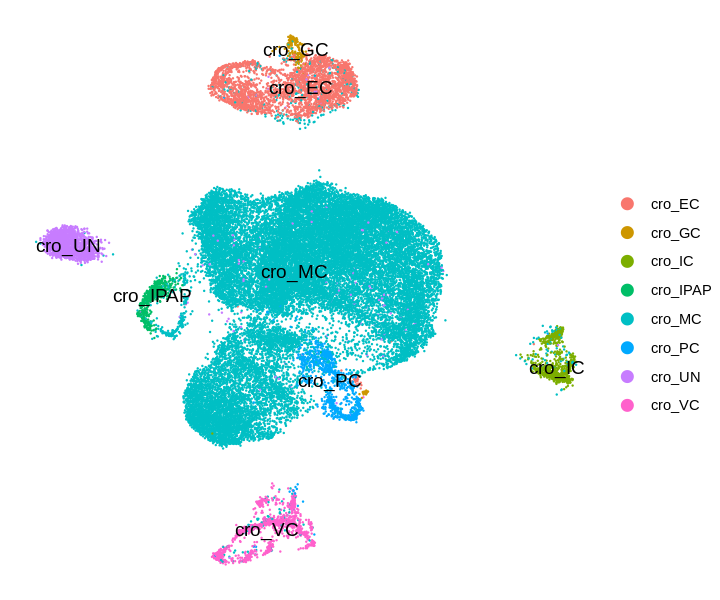

In [12]:
options(repr.plot.height = 5, repr.plot.width = 6)
load(file = "/data/Matthew/scrna/02.Clustering/crov7_alv_mincell5.Rdata")
# new cluster names
new.cluster.ids <- c("MC", "MC", "MC", "MC", "MC",
                     "MC", "EC", "UN", "VC", "EC",
                     "PC", "IC", "IPAP", "MC")

# Add seurat object levels to new.cluster.ids
names(new.cluster.ids) <- levels(seurat_obj)
# Rename clusters
seurat_obj <- RenameIdents(seurat_obj, new.cluster.ids)
seurat_obj[["old.ident"]] <- Idents(object = seurat_obj)

# find sub clusters
for (i in c("EC")) {
  seurat_obj <- FindSubCluster(seurat_obj, cluster = i,
                               graph.name = "RNA_snn",
                               resolution = 0.4,
                               algorithm = 1)
  sub_name <- as.factor(seurat_obj@meta.data$sub.cluster)
  names(sub_name) <- names(seurat_obj@active.ident)
  seurat_obj@active.ident <- sub_name
}
# add name to clusters
seurat_obj[["seurat_clusters"]] <- seurat_obj@active.ident
# new cluster names
new.cluster.ids <- paste("cro_",
    c("EC", "EC", "EC", "EC", "EC", "GC",
      "IC", "IPAP", "MC", "PC", "UN", "VC"), sep = "")
# Add seurat object levels to new.cluster.ids
names(new.cluster.ids) <- levels(seurat_obj)
# Rename clusters
seurat_obj <- RenameIdents(seurat_obj, new.cluster.ids)

DimPlot(seurat_obj, reduction = "umap", label = TRUE) + theme_void()

In [16]:
cro_exp <- AverageExpression(seurat_obj)
cro_index <- cro_exp$RNA %>%
  as.data.frame() %>% 
  rownames_to_column(var = "cro_id") %>% 
  as_tibble() %>% 
  rowwise() %>%
  mutate(
    mean_gC = sum(c_across(cro_EC:cro_VC)) / 8,
    MC_cro = cro_MC / mean_gC,
    UN_cro = cro_UN / mean_gC,
    PC_cro = cro_PC / mean_gC,
    IPAP_cro = cro_IPAP / mean_gC,
    IC_cro = cro_IC / mean_gC,
    EC_cro = cro_EC / mean_gC,
    VC_cro = cro_VC / mean_gC,
    GC_cro = cro_GC / mean_gC
  ) %>%
  select(cro_id, MC_cro:GC_cro) %>% 
  identity()

rbh <- read.table(paste(id_path, 'cro_zma.rbh.tsv',sep = '/'), col.names = c("cro_id", "zma_id")) %>% as_tibble()

cro_sub_index <- left_join(rbh, cro_index)
zma_sub_index <- left_join(rbh, zma_index)

cor_spearman <-
  left_join(cro_sub_index, zma_sub_index) %>% 
  select(-c("cro_id", "zma_id")) %>%
  drop_na() %>%
  cor(method = "spearman") %>%
  identity()

Joining, by = "cro_id"

Joining, by = "zma_id"

Joining, by = c("cro_id", "zma_id")



In [17]:
cor_spearman

,MC_cro,UN_cro,PC_cro,IPAP_cro,IC_cro,EC_cro,VC_cro,GC_cro,VC_zma,MC_zma,EC_zma,Stem_zma,G2M_zma,S_zma
MC_cro,1.000000000,0.603633452,0.007940458,0.441245352,0.30401390,-0.05372819,-0.38001580,-0.34079894,0.022104402,0.13391768,0.03853348,0.080498219,0.02526927,0.03459988
UN_cro,0.603633452,1.000000000,-0.047045350,0.362222634,0.27528350,-0.09001239,-0.32623253,-0.26934583,-0.077162799,0.11257608,-0.06924377,-0.006728793,-0.07428154,0.03804112
PC_cro,0.007940458,-0.047045350,1.000000000,0.025057033,-0.04288459,-0.28749040,-0.02104596,-0.16985604,-0.048389228,0.01555627,-0.03081640,-0.083845773,0.12054258,0.14012219
IPAP_cro,0.441245352,0.362222634,0.025057033,1.000000000,0.22626256,-0.21242767,-0.20283872,-0.23792889,-0.009895024,0.13235340,-0.03782166,0.014005562,-0.01712438,0.05648612
IC_cro,0.304013898,0.275283495,-0.042884590,0.226262564,1.00000000,-0.17954373,-0.15844001,-0.29876716,-0.086736123,0.16380884,-0.09630899,-0.019422762,-0.08250224,0.01310484
EC_cro,-0.053728189,-0.090012391,-0.287490399,-0.212427671,-0.17954373,1.00000000,-0.07915270,0.28572184,0.105785852,-0.04580858,0.17652726,0.105520755,0.03828625,-0.03828544
VC_cro,-0.380015799,-0.326232526,-0.021045960,-0.202838722,-0.15844001,-0.07915270,1.00000000,-0.01275111,0.030680330,-0.07957351,-0.09161082,-0.063198172,-0.05835395,0.13071889
GC_cro,-0.340798939,-0.269345827,-0.169856036,-0.237928888,-0.29876716,0.28572184,-0.01275111,1.00000000,0.085770363,-0.02552135,0.14261567,0.090108472,0.08716434,0.03275882
VC_zma,0.022104402,-0.077162799,-0.048389228,-0.009895024,-0.08673612,0.10578585,0.03068033,0.08577036,1.000000000,0.14533224,0.49347416,0.473394491,0.38827319,-0.13286220
MC_zma,0.133917683,0.112576078,0.015556266,0.132353400,0.16380884,-0.04580858,-0.07957351,-0.02552135,0.145332236,1.00000000,0.20853870,0.294967959,0.14330299,-0.36325762


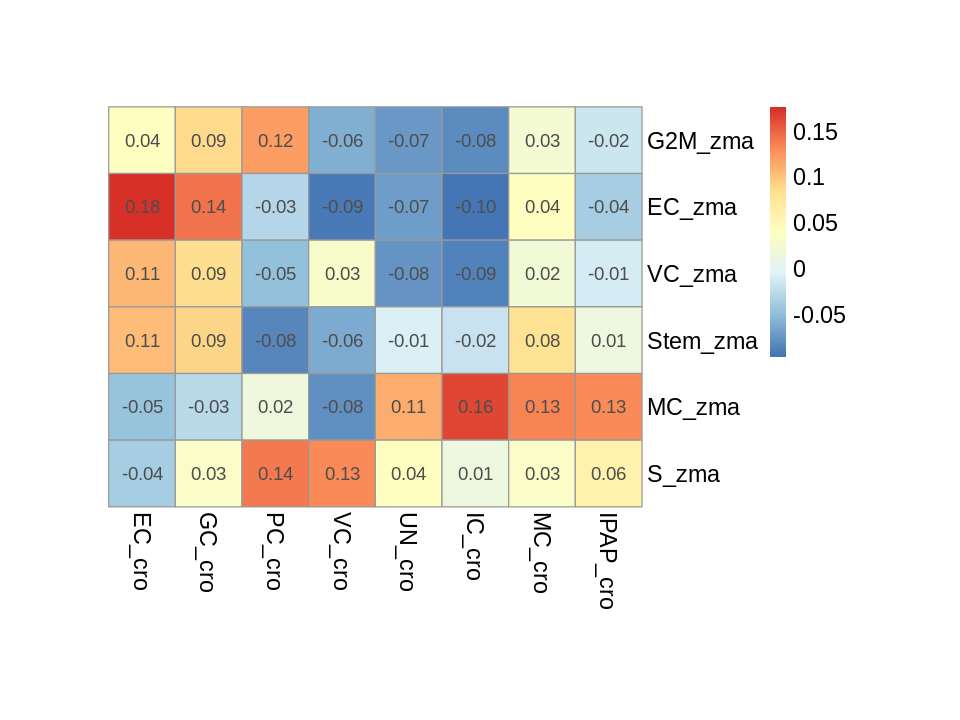

In [18]:
options(repr.plot.height = 6, repr.plot.width = 8)
pheatmap(cor_spearman[9:14, 1:8],
         display_numbers = T,
         fontsize = 14,
         treeheight_row = 0,
         treeheight_col = 0,
         cellwidth = 40,
         cellheight = 40,
         )

In [13]:
pheatmap(cor_spearman[9:13, 1:8],
         display_numbers = F,
         fontsize = 14,
         treeheight_row = 0,
         treeheight_col = 0,
         cellwidth = 40,
         cellheight = 40,
         filename = "leaf_compare_cor.pdf")

In [14]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/Matthew/miniconda3/envs/psdtime/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12    forcats_0.5.1      stringr_1.4.0      purrr_0.3.4       
 [5] readr_1.4.0        tidyr_1.1.3        tibble_3.1.3       tidyverse_1.3.1   
 [9] ggsci_2.9          ggplot2_3.3.5      dplyr_1.0.7        tximport_1.18.0   
[13] SeuratObject_4.0.2 Seurat_4.0.3      

loaded via a